# DDI Project 2    GraphLab (TuriCreate)


## 0. Initialize Part


In [1]:
import turicreate as tc
import pandas as pd
from datetime import datetime
import turicreate.aggregate as agg
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
# %matplotlib notebook

### 0.1 Read Telecomunication Data

In [2]:
col_name = ['SquareID','Timeinterval','CountryCode','SMSin','SMSout','CallIn','CallOut', 'Internet']
mi_tele_data_pd = pd.DataFrame()
tr_tele_data_pd = pd.DataFrame()

for k in glob.glob('DDI_Data/milano/milano_telecom/*'):
    df = pd.read_csv(k,delimiter='\t', header=None, names=col_name)
    df = df.loc[:,['SquareID','Timeinterval','SMSin','SMSout','CallIn','CallOut','Internet']].fillna(0)
    mi_tele_data_pd = mi_tele_data_pd.append(df)

for k in glob.glob('DDI_Data/trentino/trento_telecom/*'):
    df = pd.read_csv(k,delimiter='\t', header=None, names=col_name)
    df = df.loc[:,['SquareID','Timeinterval','SMSin','SMSout','CallIn','CallOut','Internet']].fillna(0)
    tr_tele_data_pd = tr_tele_data_pd.append(df)

mi_tele_data_ori = tc.SFrame(mi_tele_data_pd)
tr_tele_data_ori = tc.SFrame(tr_tele_data_pd)

### 0.2 Define 3 funtions based on SFrame
convert_time() : to convert time from timestamp to normal time and adjust the timezone.  
merge_inout() : to merge the Call and SMS in&out (e.g. SMS = SMSin + SMSout).  
merge_by() : to groupby each columns.\n


In [3]:
date = ['20131126','20131127','20131128','20131224','20131225','20131226']

def convert_time(sf):
    sf['Date'] = sf['Timeinterval'].apply(lambda t:datetime.utcfromtimestamp(t/1000+3600).strftime('%Y%m%d'))
    sf['Time'] = sf['Timeinterval'].apply(lambda t:datetime.utcfromtimestamp(t/1000+3600).strftime('%H%M'))
    sf['Date&Time'] = sf['Timeinterval'].apply(lambda t:datetime.utcfromtimestamp(t/1000+3600).strftime('%m%d%H%M'))
    return sf

def merge_inout(sf):
    sf['SMS'] = sf.apply(lambda x : x['SMSin']+x['SMSout'])
    sf['Call'] = sf.apply(lambda x : x['CallIn']+x['CallOut'])
    return sf

def merge_by(sf,col_name):
    sf = sf.groupby(key_column_names = col_name, operations= {'SMSin':agg.SUM('SMSin'),
                                                             'SMSout': agg.SUM('SMSout'),
                                                             'CallIn': agg.SUM('CallIn'),                                                            
                                                             'CallOut': agg.SUM('CallOut'),                    
                                                             'Internet': agg.SUM('Internet')})    
    return sf 

In [4]:
# To convert SFrame to DataFrame and order by Date
def sf_to_df_order_date(sf):
    sf = sf.to_dataframe().sort_values(['Date'], ascending=True).set_index('Date')
    return sf

### 0.3 Use convert_time() to convert  telecomunication data time

In [5]:
mi_tele_data = convert_time(mi_tele_data_ori)
tr_tele_data = convert_time(tr_tele_data_ori)

## 1. Find the most congested communication period of the day in Milan and Trentino.

### 1.1 Merge by 'Time' and then merge in&out of Call and SMS

In [6]:
# Time : HHMM , e.g. 1200 means 12:00
mi_congest = merge_by(mi_tele_data,'Time')
tr_congest = merge_by(tr_tele_data,'Time')

# Merge in&out of Call and SMS
mi_congest = merge_inout(mi_congest)
tr_congest = merge_inout(tr_congest)

### 1.2 Find the most congested time period

In [7]:
def find_most_congested(sf):
    SMS_Result = sf.sort('SMS',ascending=False).head(1)
    Call_Result=sf.sort('Call',ascending=False).head(1)
    Internet_Result=sf.sort('Internet',ascending=False).head(1)
    print('SMS The most congested communication period of the day:',SMS_Result['Time'])
    print('Call The most congested communication period of the day:',Call_Result['Time'])
    print('Internet The most congested communication period of the:',Internet_Result['Time'])

In [8]:
find_most_congested(mi_congest)
find_most_congested(tr_congest)
# In results, ['1200'] means 12:00-12:10, ['1150'] means 11:50-12:00 and so on.

SMS The most congested communication period of the day: ['1200']
Call The most congested communication period of the day: ['1200']
Internet The most congested communication period of the: ['1400']
SMS The most congested communication period of the day: ['1150']
Call The most congested communication period of the day: ['1140']
Internet The most congested communication period of the: ['1740']


### 1.3 Plot the Tele Activities Distribution of a day (24 hours)

Text(0.5, 1.0, 'Tele Activities Distribution in Trentino')

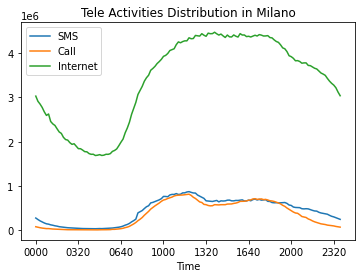

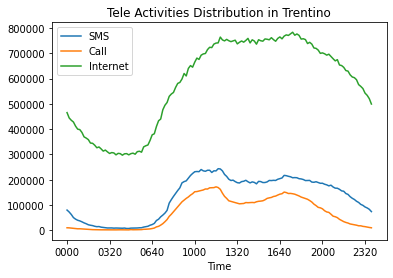

In [9]:
# I used pandas.dataframe.plot(), which used matplotlib.
# Use .to_dataframe() convert SFrame to pandas.dataframe

mi_congest_pd = mi_congest.to_dataframe().sort_values(['Time'], ascending=True).set_index('Time')
mi_congest_pd.plot(y =['SMS','Call','Internet'])
plt.title('Tele Activities Distribution in Milano')

tr_congest_pd = tr_congest.to_dataframe().sort_values(['Time'], ascending=True).set_index('Time')
tr_congest_pd.plot(y =['SMS','Call','Internet'])
plt.title('Tele Activities Distribution in Trentino')

## 2. Top 5 provinces which are most called by residents of Milan and Trentino

### 2.1 Read Call-Provinces Data

In [10]:
mi_pro_data_pd = pd.DataFrame()
tr_pro_data_pd = pd.DataFrame()

for k in glob.glob('DDI_Data/milano/milano_provinces/*'):
    df = pd.read_csv(k,delimiter='\t', header=None, names=['SquareID','Province','Timeinterval','S2P_Inter','P2S_Inter'])
    df = df.loc[:,['Province','Timeinterval']].fillna(0)
    mi_pro_data_pd = mi_pro_data_pd.append(df)

for k in glob.glob('DDI_Data/trentino/trento_provinces/*'):
    df = pd.read_csv(k,delimiter='\t', header=None, names=['SquareID','Province','Timeinterval','S2P_Inter','P2S_Inter'])
    df = df.loc[:,['Province','Timeinterval']].fillna(0)
    tr_pro_data_pd = tr_pro_data_pd.append(df)
    
mi_pro_data = tc.SFrame(mi_pro_data_pd)
tr_pro_data = tc.SFrame(tr_pro_data_pd)

### 2.2 Count the total number of each provinces, then sort

In [11]:
# Use agg.COUNT() to count, use .sort() to sort
mi_pro = mi_pro_data.groupby(key_column_names = 'Province', operations= {'count': agg.COUNT()}).sort('count',ascending=False)
tr_pro = tr_pro_data.groupby(key_column_names = 'Province', operations= {'count': agg.COUNT()}).sort('count',ascending=False)

In [12]:
# Top 5 provinces which are most called by residents of Milan
mi_pro.head(5)

Province,count
MILANO,3059130
MONZA E DELLA BRIANZA,776056
PAVIA,679429
NAPOLI,418179
VARESE,355843


In [13]:
# Top 5 provinces which are most called by residents of Trentino
tr_pro.head(5)

Province,count
TRENTO,3393381
BOLZANO/BOZEN,1020372
BRESCIA,672483
VERONA,594902
MILANO,454163


## 3. Top 5 languages tweeted by distinct users in Milan. How popular.

### 3.1 Read Tweet Data

In [14]:
mi_sp_data_pd = pd.DataFrame()
tr_sp_data_pd = pd.DataFrame()


df = pd.read_csv('DDI_Data/milano/social_pulse/social_pulse_milano.csv',\
                 delimiter='\t', header=None, \
                 names=['user','language','municipality','timestamp','latitude', 'longitude'])
mi_sp_data_pd = mi_sp_data_pd .append(df)

mi_sp_data = tc.SFrame(mi_sp_data_pd)

### 3.2 Count the total number of language, then sort

In [15]:
# Use agg.COUNT() to count, use .sort() to sort
mi_sp = mi_sp_data.groupby(key_column_names = 'language', operations= {'count': agg.COUNT()}).sort('count',ascending=False)

In [16]:
mi_sp.head(5)

language,count
it,163889
en,47830
es,7745
tl,6815
pt,5162


### 3.3 Find where is the Finnish

In [17]:
for i in range(0,len(mi_sp['language'])):
    if 'fi' == mi_sp[i]['language']:
        k = i+1
        c = mi_sp[i]['count']
        print('Finnish is the No.%d popular language, with the count:' %k,c)

Finnish is the No.15 popular language, with the count: 1594


## 4. Compare call and internet activity between 6 days

In [18]:
# Mergy by 'Date'
mi_compare_day=merge_by(mi_tele_data,'Date')

# Mergy in&out
mi_compare_day = merge_inout(mi_compare_day)

### 4.1 Plot Milano Call and Internet Activities Distribution in 6 days

Text(0.5, 1.0, 'Milano Call and Internet Activities Distribution')

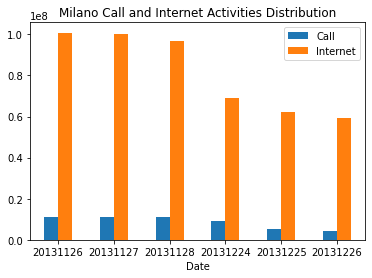

In [19]:
# I used pandas.dataframe.plot() to plot, which used matplotlib.
# Use .to_dataframe() convert SFrame to pandas.dataframe

mi_compare_day_pd = sf_to_df_order_date(mi_compare_day)
mi_compare_day_pd.plot.bar(y =['Call','Internet'],rot=0)
plt.title('Milano Call and Internet Activities Distribution')
# plt.savefig("Milano Call and Internet Activities Distribution.png", bbox_inches='tight', pad_inches=0.1)

### 4.2 Plot Milano Call and Internet Activities Distribution each days

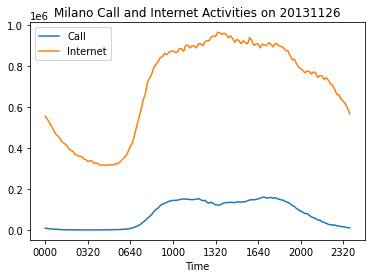

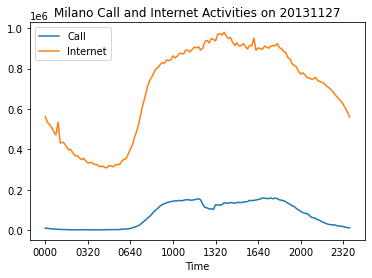

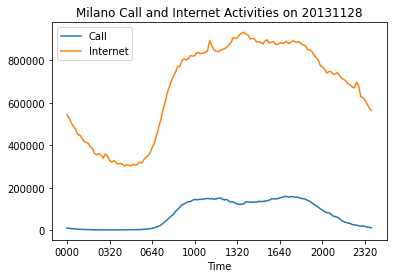

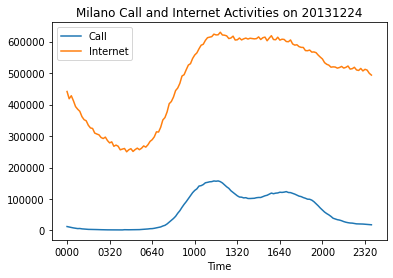

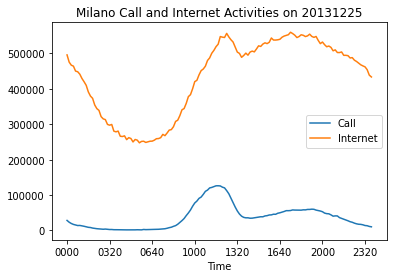

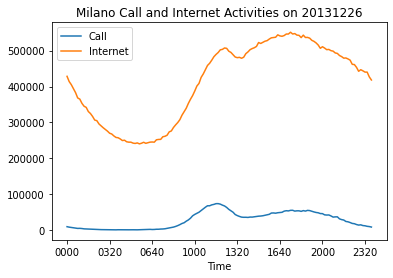

In [20]:
sub_sf_q4 = merge_inout(mi_tele_data)['Date','Time','Call','Internet']

for i in date:
    a = sub_sf_q4.filter_by(filter(lambda x : x==i,sub_sf_q4['Date']),'Date')
    a = a.groupby(key_column_names = 'Time', operations= {'Call':agg.SUM('Call'),
                                                      'Internet': agg.SUM('Internet')}) 
    a = a.to_dataframe()
    a = a.sort_values(['Time'], ascending=True).set_index('Time')
    a.plot(title='Milano Call and Internet Activities on %s'%i)

## 5. Find correlation between user communication activity and different weather conditions (e.g. rain, snow etc.) in Milan and Trentino.

In [21]:
# convert_time2() : to convert time to easy-using time form.
def convert_time2(sf):
    sf['Date&Time'] = sf['Timeinterval'].apply(lambda t: repr(t)[4:])
    sf['Date'] = sf['Timeinterval'].apply(lambda t: repr(t)[:8])
    return sf

### 5.1 Read Precipitation Data

In [22]:
tr_prec_data_pd = pd.DataFrame()
mi_prec_data_pd = pd.DataFrame()

df = pd.read_csv('DDI_Data/trentino/trento_precipitation_data/precipitation-trentino.csv',\
                 delimiter=',', header=None, \
                 names=['Timeinterval','SquareID','Intensity'])
tr_prec_data_pd = tr_prec_data_pd.append(df)

tr_prec_data = tc.SFrame(tr_prec_data_pd)

df = pd.read_csv('DDI_Data/milano/milano_precipitation/MeteoMilano_01-11-13_01-01-14.csv',\
                 delimiter=',', header=None, \
                 names=['Timeinterval','Quadrant','Intensity','Coverage','Type'])
mi_prec_data_pd = mi_prec_data_pd.append(df)

mi_prec_data = tc.SFrame(mi_prec_data_pd)

### 5.2 Figure out which are clear days which are rain/snow

In [23]:
tr_prec_data2 = convert_time2(tr_prec_data)
tr_prec_data3 = tr_prec_data2.filter_by(date,'Date')
tr_prec_data3['ID&Time'] = tr_prec_data3.apply(lambda x : str(x['SquareID'])+str(x['Date&Time']))
tr_prec_data4 = tr_prec_data3.select_columns(['ID&Time','Intensity'])

In [24]:
tr_tele_data_q5 = tr_tele_data.copy().remove_columns(['Timeinterval','Date'])
tr_tele_data_q5['ID&Time'] = tr_tele_data_q5.apply(lambda x : str(x['SquareID'])+str(x['Date&Time']))

In [25]:
tr_prec_data5 = tr_tele_data_q5.join(tr_prec_data4,how='inner')

In [26]:
# Use .filter_by() to spilt clear days or rain/snow days
# In the data, Intensity is 1-18, so I treat 1 as clear, others as rain/snow

tr_prec_data_rain = tr_prec_data5.filter_by(1,'Intensity',exclude=True)
tr_prec_data_rain = merge_by(tr_prec_data_rain,'Time')
tr_prec_data_rain = merge_inout(tr_prec_data_rain)

tr_prec_data_clear = tr_prec_data5.filter_by(1,'Intensity',exclude=False)
tr_prec_data_clear = merge_by(tr_prec_data_clear,'Time')
tr_prec_data_clear = merge_inout(tr_prec_data_clear)

<AxesSubplot:title={'center':'Clear day in Trentino'}, xlabel='Time'>

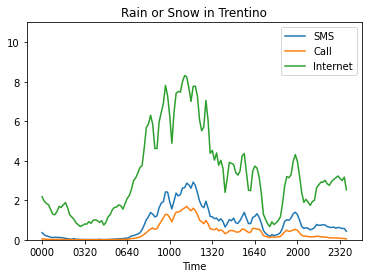

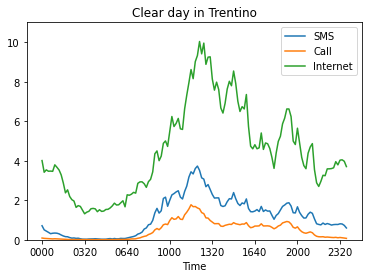

In [27]:
tr_prec_data_rain_pd = tr_prec_data_rain.to_dataframe().sort_values(['Time'], ascending=True).set_index('Time')
tr_prec_data_rain_pd[['SMS','Call','Internet']]=tr_prec_data_rain_pd[['SMS','Call','Internet']]/10000
tr_prec_data_rain_pd.plot(y =['SMS','Call','Internet'],ylim = (0,11),title='Rain or Snow in Trentino')

tr_prec_data_clear_pd = tr_prec_data_clear.to_dataframe().sort_values(['Time'], ascending=True).set_index('Time')
tr_prec_data_clear_pd[['SMS','Call','Internet']]=tr_prec_data_clear_pd[['SMS','Call','Internet']]/17500
tr_prec_data_clear_pd.plot(y =['SMS','Call','Internet'],ylim = (0,11),title='Clear day in Trentino')

In [28]:
mi_tele_data_q5 = mi_tele_data.copy().remove_columns(['Timeinterval','Date'])
mi_tele_data_q5['ID&Time'] = mi_tele_data_q5.apply(lambda x : str(x['SquareID'])+str(x['Date&Time']))

In [29]:
mi_prec_data2 = mi_prec_data.groupby(key_column_names = 'Timeinterval', operations= {'Intensity':agg.AVG('Intensity')})    

In [30]:
mi_prec_data3 = convert_time2(mi_prec_data2).remove_columns(['Timeinterval'])

mi_prec_data4 = mi_prec_data3.filter_by(date,'Date')

In [31]:
mi_prec_data5 = mi_tele_data_q5.join(mi_prec_data4,how='inner')

In [32]:
# Use .filter_by() to spilt clear days or rain/snow days
# In the data, Intensity is 0-3, so I treat 0 as clear, others as rain/snow

mi_prec_data_rain = mi_prec_data5.filter_by(float(0),'Intensity',exclude=True)
mi_prec_data_rain = merge_by(mi_prec_data_rain,'Time')
mi_prec_data_rain = merge_inout(mi_prec_data_rain)

mi_prec_data_clear = mi_prec_data5.filter_by(float(0),'Intensity',exclude=False)
mi_prec_data_clear = merge_by(mi_prec_data_clear,'Time')
mi_prec_data_clear = merge_inout(mi_prec_data_clear)

<AxesSubplot:title={'center':'Clear day in Milano'}, xlabel='Time'>

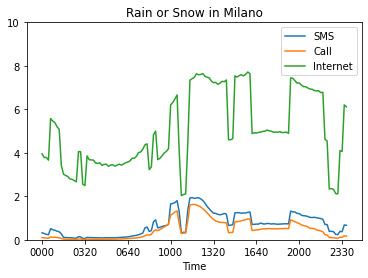

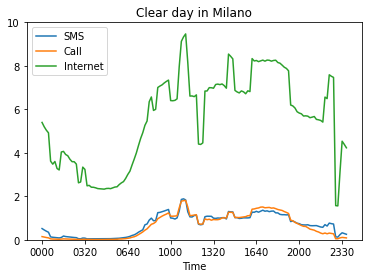

In [33]:
#Plot 
mi_prec_data_rain_pd = mi_prec_data_rain.to_dataframe().sort_values(['Time'], ascending=True).set_index('Time')
mi_prec_data_rain_pd[['SMS','Call','Internet']]=mi_prec_data_rain_pd[['SMS','Call','Internet']]/(2.2*1e5)
mi_prec_data_rain_pd.plot(y =['SMS','Call','Internet'],ylim = (0,10),title='Rain or Snow in Milano')

mi_prec_data_clear_pd = mi_prec_data_clear.to_dataframe().sort_values(['Time'], ascending=True).set_index('Time')
mi_prec_data_clear_pd[['SMS','Call','Internet']]=mi_prec_data_clear_pd[['SMS','Call','Internet']]/(4*1e5)
mi_prec_data_clear_pd.plot(y =['SMS','Call','Internet'],ylim = (0,10),title='Clear day in Milano')

## 6. Plot the heatmap of user telecommunication activity for both Milan and Trentino.

In [34]:
# Use geopandas to plot heatmap
def gpd_plot_heatmap(df,col,vmax,name):
    df.plot(column=col,legend=True,cmap="YlGn",vmin=0, vmax=vmax)
    plt.title(name)
#     plt.savefig("%s.png" %name, bbox_inches='tight', pad_inches=0.1)

# Processing function
def process_q6(sf):
    sf = merge_by(sf,'SquareID')
    sf = merge_inout(sf)
    sf = sf.select_columns(['SquareID','Internet','SMS','Call'])
    sf = sf.rename({'SquareID':'cellId'})
    sf = sf.to_dataframe()
    return sf

In [35]:
mi_tele_data_q6 = mi_tele_data.copy()
mi_tele_data_q6['Time'] = mi_tele_data_q6['Time'].apply(lambda x:int(x))

In [36]:
# Devide into day or night
mi_tele_data_day = mi_tele_data_q6.filter_by(range(800,2000),'Time',exclude=False)
mi_tele_data_night = mi_tele_data_q6.filter_by(range(800,2000),'Time',exclude=True)

In [37]:
# Read geo data
mi_geo =  gpd.read_file('DDI_Data/milano/milano-grid/milano-grid.geojson')

In [38]:
# Use geopandas .merge() to join

mi_tele_data_night_pd = process_q6(mi_tele_data_night)
mi_tele_data_night_pd = mi_geo.merge(mi_tele_data_night_pd,on='cellId')

mi_tele_data_day_pd = process_q6(mi_tele_data_day)
mi_tele_data_day_pd = mi_geo.merge(mi_tele_data_day_pd,on='cellId')

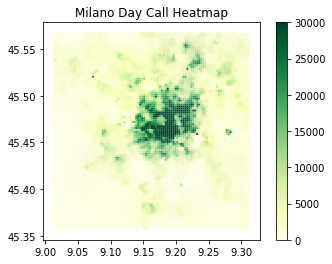

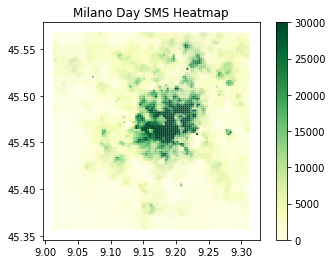

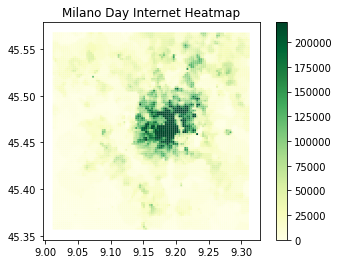

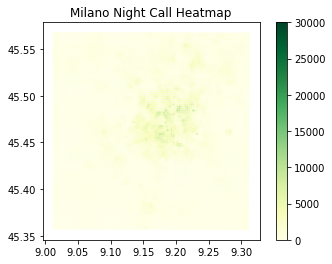

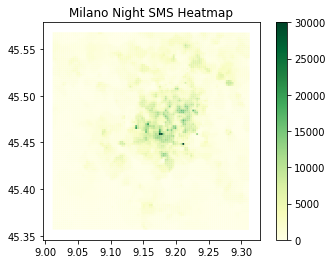

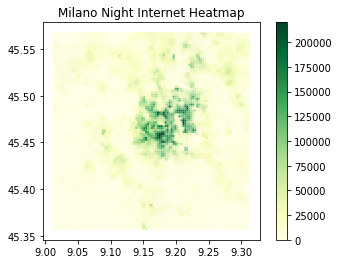

In [39]:
# Plot
gpd_plot_heatmap(mi_tele_data_day_pd,'Call',30000,'Milano Day Call Heatmap')
gpd_plot_heatmap(mi_tele_data_day_pd,'SMS',30000,'Milano Day SMS Heatmap')
gpd_plot_heatmap(mi_tele_data_day_pd,'Internet',220000,'Milano Day Internet Heatmap')

gpd_plot_heatmap(mi_tele_data_night_pd,'Call',30000,'Milano Night Call Heatmap')
gpd_plot_heatmap(mi_tele_data_night_pd,'SMS',30000,'Milano Night SMS Heatmap')
gpd_plot_heatmap(mi_tele_data_night_pd,'Internet',220000,'Milano Night Internet Heatmap')

In [40]:
tr_tele_data_q6 = tr_tele_data.copy()
tr_tele_data_q6['Time'] = tr_tele_data_q6['Time'].apply(lambda x:int(x))

In [41]:
# Devide into day or night
tr_tele_data_day = tr_tele_data_q6.filter_by(range(800,2000),'Time',exclude=False)
tr_tele_data_night = tr_tele_data_q6.filter_by(range(800,2000),'Time',exclude=True)

In [42]:
# Read geo data
tr_geo = gpd.read_file('DDI_Data/trentino/trentino-grid/trentino-grid.geojson')

In [43]:
# Use geopandas .merge() to join

tr_tele_data_night_pd = process_q6(tr_tele_data_night)
tr_tele_data_night_pd = tr_geo.merge(tr_tele_data_night_pd,on='cellId')

tr_tele_data_day_pd = process_q6(tr_tele_data_day)
tr_tele_data_day_pd = tr_geo.merge(tr_tele_data_day_pd,on='cellId')

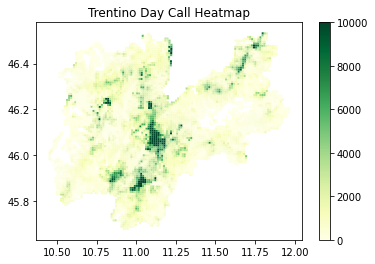

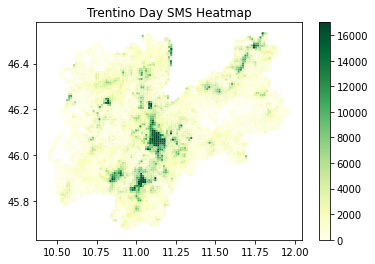

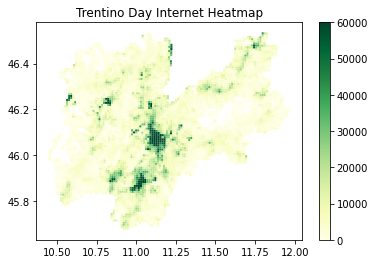

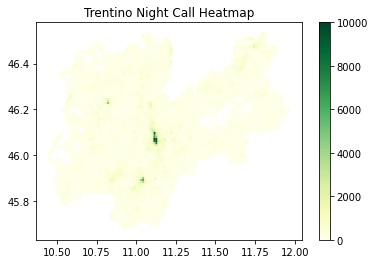

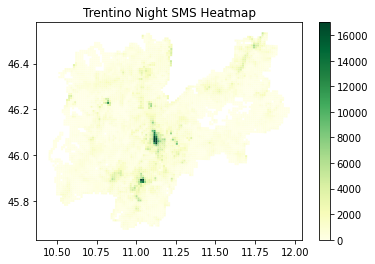

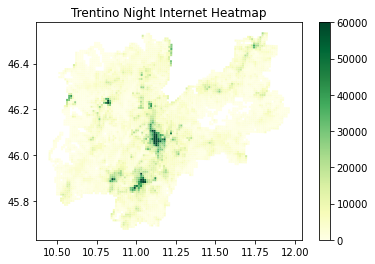

In [44]:
# Plot
gpd_plot_heatmap(tr_tele_data_day_pd,'Call',10000,'Trentino Day Call Heatmap')
gpd_plot_heatmap(tr_tele_data_day_pd,'SMS',17000,'Trentino Day SMS Heatmap')
gpd_plot_heatmap(tr_tele_data_day_pd,'Internet',60000,'Trentino Day Internet Heatmap')

gpd_plot_heatmap(tr_tele_data_night_pd,'Call',10000,'Trentino Night Call Heatmap')
gpd_plot_heatmap(tr_tele_data_night_pd,'SMS',17000,'Trentino Night SMS Heatmap')
gpd_plot_heatmap(tr_tele_data_night_pd,'Internet',60000,'Trentino Night Internet Heatmap')

## 7. plot the correlation between air quality and weather (Precipitation here)

In [45]:
# convert_time3() : to convert time to easy-using time form.
def convert_time3(sf):
    sf['Date'] = sf['Timeinterval'].apply(lambda t: t[5:7]+t[8:10])
    return sf

def read_weather(id):
    df2 = pd.DataFrame()
    for k in id:
        df = pd.read_csv('DDI_Data/milano/Milano_WeatherPhenomena/mi_meteo_%s.csv'%k,delimiter=',', header=None, names=['ID','Timeinterval','Uom'])
        df2 = df2.append(df)
        sf = convert_time3(tc.SFrame(df2))
        sf['Uom']=sf['Uom']/max(sf['Uom'])
    return sf

### 7.1 Read Pollution Data

In [46]:
mi_pollution_pd = pd.DataFrame()

for k in glob.glob('DDI_Data/milano/milano_airQuality/mi_pollution*'):
    df = pd.read_csv(k,delimiter=',', header=None, names=['ID','Timeinterval','Pollution'])
    mi_pollution_pd = mi_pollution_pd.append(df)

mi_pollution = tc.SFrame(mi_pollution_pd)



In [47]:
mi_pollution2 = convert_time3(mi_pollution).groupby(['ID','Date'],{'Pollution':agg.AVG('Pollution')})
mi_pollution3 = mi_pollution2.groupby(['Date'],{'Pollution':agg.AVG('Pollution')})
# Scaling 'Pollution' to 0-1
mi_pollution3['Pollution'] = mi_pollution3['Pollution']/(max(mi_pollution3['Pollution']))

### 7.2 Get Weather Data

In [48]:
mi_weather_legend_pd = pd.DataFrame()

for k in glob.glob('DDI_Data/milano/Milano_WeatherPhenomena/mi_meteo_legend*'):
    df = pd.read_csv(k,delimiter=',', header=None, names=['ID','Position','Lat','Lon','Type','Unit'])
    mi_weather_legend_pd = mi_weather_legend_pd.append(df)

mi_weather_legend = tc.SFrame(mi_weather_legend_pd)

#### 7.2.1 Get Temperature Data

In [49]:
Tempe_ID = mi_weather_legend.filter_by('Temperature','Type')['ID']
print('Stations of Temperature (ID):',Tempe_ID)
mi_temp = read_weather(Tempe_ID).groupby('Date',{'Temperature':agg.AVG('Uom')})

Stations of Temperature (ID): [5897, 2001, 5920, 8162, 5909, 5911]


#### 7.2.2 Get Wind Speed Data

In [50]:
Wdsp_ID = mi_weather_legend.filter_by('Wind Speed','Type')['ID']
print('Stations of Wind Speed (ID):',Wdsp_ID)
mi_wdsp = read_weather(Wdsp_ID).groupby('Date',{'Wind Spped':agg.AVG('Uom')})

Stations of Wind Speed (ID): [6120, 14391, 6138, 19004, 19005, 6129, 6131, 19019, 19020]


#### 7.2.3 Get Precipitation Data

In [51]:
mi_prec = convert_time2(mi_prec_data)
mi_prec['Date'] = mi_prec['Date'].apply(lambda x: x[4:9])
mi_prec = mi_prec.select_columns(['Date','Intensity'])
mi_prec = mi_prec.groupby('Date',{'Pre_Intensity':agg.AVG('Intensity')})

### 7.3 Join pollution and weather

<AxesSubplot:title={'center':'Preciptation VS Air Quality'}, xlabel='Date'>

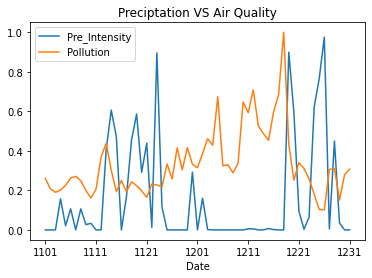

In [52]:
#Join by Date
poll_prec_q7_data = mi_prec.join(mi_pollution3)
#Plot
sf_to_df_order_date(poll_prec_q7_data).plot(title='Preciptation VS Air Quality')

<AxesSubplot:title={'center':'Temperature VS Air Quality'}, xlabel='Date'>

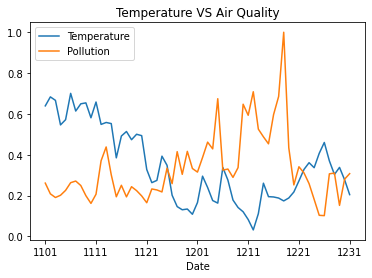

In [53]:
#Join by Date
poll_temp_q7_data = mi_temp.join(mi_pollution3)
#Plot
sf_to_df_order_date(poll_temp_q7_data).plot(title='Temperature VS Air Quality')

<AxesSubplot:title={'center':'Wind Speed VS Air Quality'}, xlabel='Date'>

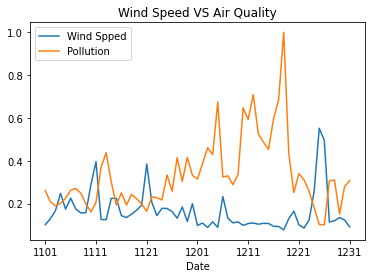

In [54]:
#Join by Date
poll_windspeed_q7_data = mi_wdsp.join(mi_pollution3)
#Plot
sf_to_df_order_date(poll_windspeed_q7_data).plot(title='Wind Speed VS Air Quality')